### Load Data and View Image ###

In this step, I load the data and reviewed the image to know the structure of the image.

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Dataset: train
Category: dogs-person, Count: 0
Category: dog, Count: 84
Category: person, Count: 97


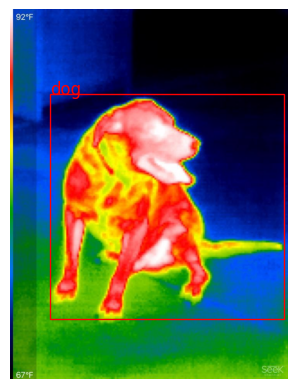

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Dataset: valid
Category: dogs-person, Count: 0
Category: dog, Count: 22
Category: person, Count: 27


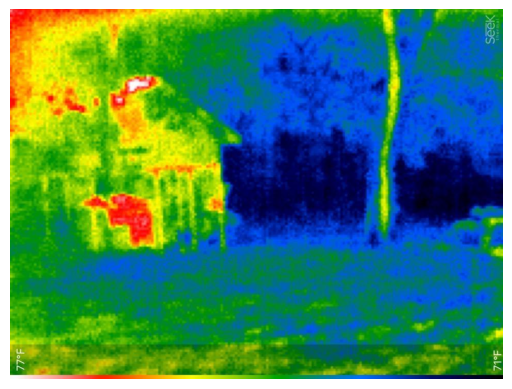

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Dataset: test
Category: dogs-person, Count: 0
Category: dog, Count: 11
Category: person, Count: 16


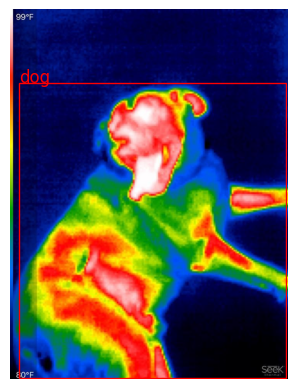

In [1]:
import os
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

data_dir = '/home/hgq/Projects/DLF/dog'
splits = ['train', 'valid', 'test']

for split in splits:
    image_dir = os.path.join(data_dir, split)
    ann_file = os.path.join(image_dir, '_annotations.coco.json')
    coco = COCO(ann_file)
    
    # Get all category IDs and their names
    cat_ids = coco.getCatIds()
    cat_names = {cat_id: coco.loadCats(cat_id)[0]['name'] for cat_id in cat_ids}
    
    # Count the number of annotations for each category
    cat_counts = {cat_id: 0 for cat_id in cat_ids}
    
    for cat_id in cat_ids:
        ann_ids = coco.getAnnIds(catIds=cat_id)
        cat_counts[cat_id] = len(ann_ids)
    
    # Print the category name and count for the current split
    print(f"\nDataset: {split}")
    for cat_id, count in cat_counts.items():
        print(f"Category: {cat_names[cat_id]}, Count: {count}")
    
    # Display one sample image with bounding boxes and labels
    img_ids = coco.getImgIds()
    img_info = coco.loadImgs(img_ids[0])[0] 
    image_path = os.path.join(image_dir, img_info['file_name'])
    image = Image.open(image_path)
    
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    plt.axis('off')
    
    ann_ids = coco.getAnnIds(imgIds=img_info['id'])
    annotations = coco.loadAnns(ann_ids)
    
    for ann in annotations:
        bbox = ann['bbox']
        category_id = ann['category_id']
        category_name = cat_names[category_id]
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(bbox[0], bbox[1], category_name, color='red', fontsize=12)
    
    plt.show()


### Calculate the mean and standard deviation ###

This step I calculate the mean and standard deviation of training dataset. By accumulating the mean and standard deviation across all images, it can provide overall dataset statistics. These values can be used to standardize the dataset by scaling pixel values, which can improve model convergence and training stability.

In [2]:
import torch
from torchvision import transforms
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import copy

train_ann = "/home/hgq/Projects/DLF/dog/train/_annotations.coco.json"
valid_ann = "/home/hgq/Projects/DLF/dog/valid/_annotations.coco.json"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

train_dir = '/home/hgq/Projects/DLF/dog/train'
dataset = CustomDataset(train_dir, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

mean = 0.0
std = 0.0
total_images_count = 0

for images in loader:
    batch_images_count = images.size(0)
    images = images.view(batch_images_count, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += batch_images_count

mean /= total_images_count
std /= total_images_count

print("Mean:", mean)
print("Standard Deviation:", std)


Mean: tensor([0.2885, 0.3756, 0.3216])
Standard Deviation: tensor([0.3790, 0.2832, 0.2951])


### Resnet-18 Implementation ###

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2885, 0.3756, 0.3216], std=[0.3790, 0.2832, 0.2951])
])

class CustomCOCODataset(Dataset):
    def __init__(self, image_dir, ann_file, transform=None):
        self.coco = COCO(ann_file)
        self.img_ids = self.coco.getImgIds()
        self.image_dir = image_dir
        self.transform = transform
        self.img_ids = [img_id for img_id in self.img_ids if len(self.coco.getAnnIds(imgIds=img_id)) > 0]

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        image_path = os.path.join(self.image_dir, img_info['file_name'])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)
        label = annotations[0]['category_id']
        return image, label

# Define Resnet-18
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, use_residual_links=True):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.use_residual_links = use_residual_links

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.use_residual_links:
            out += identity
        
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=3, use_residual_links=True):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        # Initial Convolutional Layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual Blocks with parameter use_residual_links
        self.layer1 = self._make_layer(64, 2, stride=1, use_residual_links=use_residual_links)
        self.layer2 = self._make_layer(128, 2, stride=2, use_residual_links=use_residual_links)
        self.layer3 = self._make_layer(256, 2, stride=2, use_residual_links=use_residual_links)
        self.layer4 = self._make_layer(512, 2, stride=2, use_residual_links=use_residual_links)

        # Fully Connected Layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride, use_residual_links):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers = [ResidualBlock(self.in_channels, out_channels, stride, downsample, use_residual_links)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, use_residual_links=use_residual_links))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



# Grid Search Hyper-Parameters
param_grid = {
    "learning_rate": [0.01, 0.001, 0.0001],
    "optimizer": ["Adam", "SGD"],
    "weight_decay": [0, 0.0001, 0.0005],
    "use_residual_links": [True, False]
}

def train_and_evaluate_model(learning_rate, optimizer_name, weight_decay, use_residual_links):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ResNet18(num_classes=3, use_residual_links=use_residual_links).to(device)
    early_stop_patience = 3
    best_valid_loss = float('inf')
    early_stop_counter = 0
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)


    best_model_weights = copy.deepcopy(model.state_dict())


    num_epochs = 50
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        valid_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                # print(labels)
                # print(predicted)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_valid_loss = valid_loss / len(valid_loader)
        valid_accuracy = correct / total
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(valid_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Valid Acc: {valid_accuracy:.4f}")

        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stop_patience:
                print("Early stopping triggered")
                break
    
    return best_valid_loss, best_model_weights, train_losses, valid_losses, train_accuracies, valid_accuracies


In [4]:
# Train the model and grid search

best_params = None
best_score = float('inf')
best_model_path = 'best_model.pth'
best_params_path = 'best_params.pth'
train_dataset = CustomCOCODataset(os.path.join(data_dir, 'train'), os.path.join(data_dir, 'train/_annotations.coco.json'), transform=transform)
valid_dataset = CustomCOCODataset(os.path.join(data_dir, 'valid'), os.path.join(data_dir, 'valid/_annotations.coco.json'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

for lr in param_grid['learning_rate']:
    for optimizer_name in param_grid['optimizer']:
        for weight_decay in param_grid['weight_decay']:
            for use_residual_links in param_grid['use_residual_links']:
                print(f"Training with lr={lr}, optimizer={optimizer_name}, weight_decay={weight_decay}, "
                      f"use_residual_links={use_residual_links}")
                valid_loss, best_model_weights, train_losses, valid_losses, train_accuracies, valid_accuracies = train_and_evaluate_model(
                    lr, optimizer_name, weight_decay, use_residual_links
                )
                if valid_loss < best_score:
                    best_score = valid_loss
                    best_params = {
                        'learning_rate': lr, 'optimizer': optimizer_name, 
                        'weight_decay': weight_decay, 'use_residual_links': use_residual_links
                    }
                    torch.save(best_model_weights, best_model_path)

print("Best parameters:", best_params)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Training with lr=0.01, optimizer=Adam, weight_decay=0, use_residual_links=True
Epoch [1/50], Train Loss: 1.3493, Valid Loss: 3948134.1250, Train Acc: 0.5878, Valid Acc: 0.5000
Epoch [2/50], Train Loss: 0.7922, Valid Loss: 21372.8457, Train Acc: 0.5344, Valid Acc: 0.5000
Epoch [3/50], Train Loss: 1.0705, Valid Loss: 2015.2656, Train Acc: 0.5038, Valid Acc: 0.5000
Epoch [4/50], Train Loss: 1.3566, Valid Loss: 98.6416, Train Acc: 0.5191, Valid Acc: 0.5000
Epoch [5/50], Train Loss: 0.9626, Valid Loss: 41.7907, Train Acc: 0.6031, Valid Acc: 0.5000
Epoch [6/50], Train Loss: 0.6076, Valid Loss: 6.2016, Train Acc: 0.6260, Valid Acc: 0.6944
Epoch [7/50], Train Loss: 0.5587, Valid Loss: 2.8375, Train Acc: 0.7023, Valid Acc: 0.7222
Epoch [8/50], Train Loss: 0.5522, Valid Loss: 1.4883, Train Acc: 0.7099, Valid Acc: 0.7500
Epoch [9/50]

Thus, the best parameters are learning_rate': 0.001, 'optimizer': 'SGD', 'weight_decay': 0.0005, 'use_residual_links': True.

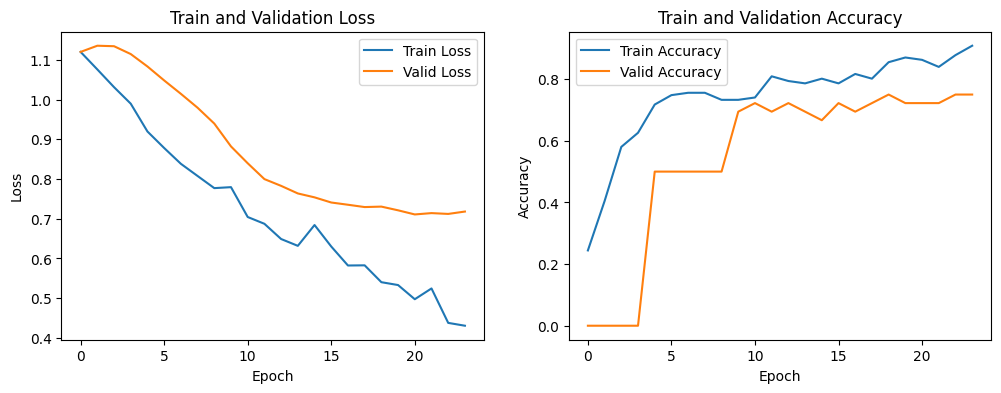

In [5]:
# Plot best model loss and accuracy curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.show()

Based on the chart, it indicates that the model early stop before the validation dataset loss getting higher, and this step can prevent overfitting. Furthermore, the train/valid loss continuously reduce while the accuracy getting higher, which means that the model learning well from the train dataset and have a good robustness on unseen data.

### Test Resnet-18 Results ###

In [6]:
from sklearn.metrics import f1_score, precision_score, recall_score

test_dataset = CustomCOCODataset(
    os.path.join(data_dir, 'test'), 
    os.path.join(data_dir, 'test/_annotations.coco.json'), 
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18(num_classes=3).to(device)
model.load_state_dict(torch.load('best_model.pth'))  

def evaluate_on_test_set(model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    
    print(f"Test F1 Score: {f1:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")


evaluate_on_test_set(model)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Test F1 Score: 0.8328
Test Precision: 0.8375
Test Recall: 0.8333


This result also indicate that the model have a good performance on unseen data.

### Compare to Other Nerual Network ###

In this section, I compare three other neural network, which is Resnet-50, VGG-19, and one lightweight model Mobilenet_v2. Given the dataset is not from Imagenet, I used pretrained version.

#### Resnet50 ####

In [16]:
from torchvision import models

# Initialize a pretrained ResNet50 model and modify the output layer to match the number of classes
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 3)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Clear cache
torch.cuda.empty_cache()

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Reset gradients to zero
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagate
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Accumulate the training loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        correct += (predicted == labels).sum().item()  # Count correct predictions
        total += labels.size(0)  # Count total samples

    train_accuracy = correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluation
model.eval()
test_loss, correct, total = 0.0, 0, 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Calculate Metrics
test_accuracy_50 = correct / total
f1_50 = f1_score(all_labels, all_predictions, average='weighted')
precision_50 = precision_score(all_labels, all_predictions, average='weighted')
recall_50 = recall_score(all_labels, all_predictions, average='weighted')

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy_50:.4f}")
print(f"F1 Score: {f1_50:.4f}, Precision: {precision_50:.4f}, Recall: {recall_50:.4f}")


/home/hgq/miniconda3/envs/mobile/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hgq/miniconda3/envs/mobile/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.9820, Accuracy: 0.4427
Epoch [2/10], Loss: 0.8295, Accuracy: 0.8015
Epoch [3/10], Loss: 0.7092, Accuracy: 0.9160
Epoch [4/10], Loss: 0.6376, Accuracy: 0.9389
Epoch [5/10], Loss: 0.5307, Accuracy: 0.9695
Epoch [6/10], Loss: 0.4810, Accuracy: 1.0000
Epoch [7/10], Loss: 0.4144, Accuracy: 1.0000
Epoch [8/10], Loss: 0.3886, Accuracy: 1.0000
Epoch [9/10], Loss: 0.3226, Accuracy: 0.9924
Epoch [10/10], Loss: 0.4099, Accuracy: 0.9924
Test Loss: 0.3927, Test Accuracy: 0.8889
F1 Score: 0.8889, Precision: 0.8889, Recall: 0.8889


ResNet-50 has greater network depth and model complexity compared to ResNet-18, which leads to improved performance on the test dataset.

#### MobileNet ####

In [8]:
# Initialize a pretrained MobileNetV2 model and modify the final classifier layer to output 3 classes
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3) # Modify final layer
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

torch.cuda.empty_cache()



num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluation
model.eval()
test_loss, correct, total = 0.0, 0, 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Calculate Metrics
test_accuracy_m = correct / total
f1_m = f1_score(all_labels, all_predictions, average='weighted')
precision_m = precision_score(all_labels, all_predictions, average='weighted')
recall_m = recall_score(all_labels, all_predictions, average='weighted')

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy_m:.4f}")
print(f"F1 Score: {f1_m:.4f}, Precision: {precision_m:.4f}, Recall: {recall_m:.4f}")


/home/hgq/miniconda3/envs/mobile/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hgq/miniconda3/envs/mobile/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.7322, Accuracy: 0.6565
Epoch [2/10], Loss: 0.3667, Accuracy: 0.8397
Epoch [3/10], Loss: 0.2042, Accuracy: 0.9160
Epoch [4/10], Loss: 0.4551, Accuracy: 0.8626
Epoch [5/10], Loss: 0.2090, Accuracy: 0.9008
Epoch [6/10], Loss: 0.2335, Accuracy: 0.9008
Epoch [7/10], Loss: 0.5287, Accuracy: 0.8779
Epoch [8/10], Loss: 0.8063, Accuracy: 0.9084
Epoch [9/10], Loss: 0.4121, Accuracy: 0.9160
Epoch [10/10], Loss: 0.2766, Accuracy: 0.8626
Test Loss: 1.4346, Test Accuracy: 0.6667
F1 Score: 0.6494, Precision: 0.7077, Recall: 0.6667


The reason that why this result lower is the mobileNet’s performance lower than ResNet-18’s. It focus on lightweight design and computational efficiency rather than maximizing feature extraction. Furthermore, ResNet-18’s residual connections help in better gradient flow and model fitting. Without these connections, MobileNet may underperform on complex patterns and features.

#### VGG-19 ####

In [12]:
# Initialize the VGG 19 and modified the final layer
from torchvision import models
from sklearn.metrics import f1_score, precision_score, recall_score

model = models.vgg19(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 3)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000005)
torch.cuda.empty_cache()


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.4f}")

model.eval()
test_loss, correct, total = 0.0, 0, 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Calculate Metrics
test_accuracy_v = correct / total
f1_v = f1_score(all_labels, all_predictions, average='weighted')
precision_v = precision_score(all_labels, all_predictions, average='weighted')
recall_v = recall_score(all_labels, all_predictions, average='weighted')

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy_v:.4f}")
print(f"F1 Score: {f1_v:.4f}, Precision: {precision_v:.4f}, Recall: {recall_v:.4f}")


/home/hgq/miniconda3/envs/mobile/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hgq/miniconda3/envs/mobile/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 1.1463, Accuracy: 0.4504
Epoch [2/10], Loss: 0.8731, Accuracy: 0.6260
Epoch [3/10], Loss: 0.6967, Accuracy: 0.6947
Epoch [4/10], Loss: 0.6197, Accuracy: 0.7557
Epoch [5/10], Loss: 0.5854, Accuracy: 0.7405
Epoch [6/10], Loss: 0.4709, Accuracy: 0.7634
Epoch [7/10], Loss: 0.5629, Accuracy: 0.8015
Epoch [8/10], Loss: 0.3943, Accuracy: 0.8702
Epoch [9/10], Loss: 0.3159, Accuracy: 0.8702
Epoch [10/10], Loss: 0.2931, Accuracy: 0.8931
Test Loss: 0.3113, Test Accuracy: 0.9444
F1 Score: 0.9443, Precision: 0.9500, Recall: 0.9444


This result improve the f1 score from 0.8328 to 0.944 compare to the Resnet-18. This is because the VGG-19 has a larger parameter count of approximately 143.7 million, particularly due to its fully connected layers, making it computationally and memory-intensive and better suited for resource-rich environments. In contrast, ResNet-18, utilizing residual connections and a shallower network structure, which lead to a lower result.

### Conclusion ###

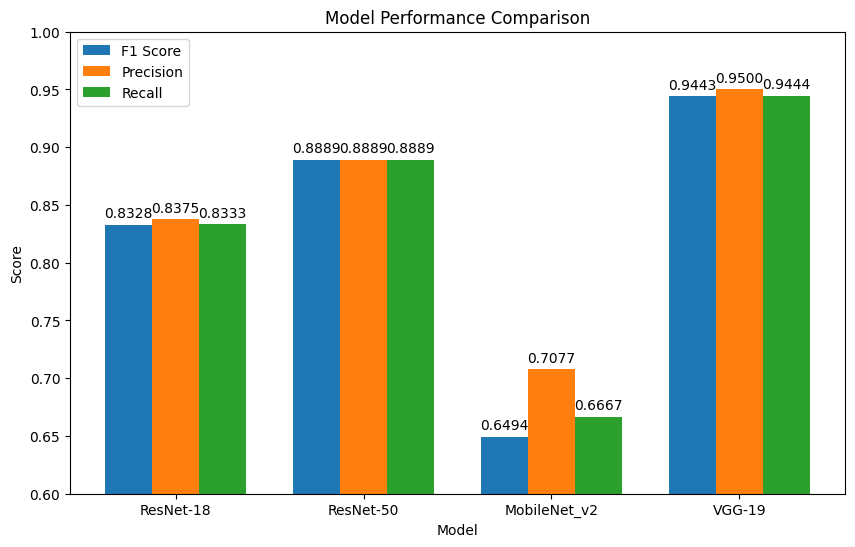

In [2]:
# Plot the Performance Distribution Chart to Compare
data = {
    "Model": ["ResNet-18", "ResNet-50", "MobileNet_v2", "VGG-19"],
    "F1 Score": [f1, f1_50, f1_m, f1_v],
    "Precision": [precision, precision_50, precision_m, precision_v],
    "Recall": [recall, recall_50, recall_m, recall_v]
}

df = pd.DataFrame(data)
df.to_csv("model_performance.csv", index=False)

x = np.arange(len(data["Model"]))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width, data["F1 Score"], width, label="F1 Score")
bar2 = ax.bar(x, data["Precision"], width, label="Precision")
bar3 = ax.bar(x + width, data["Recall"], width, label="Recall")

ax.set_ylim(0.6, 1.0)
ax.set_xlabel("Model")
ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")
ax.set_xticks(x)
ax.set_xticklabels(data["Model"])
ax.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.4f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

plt.show()


In conclusion, this experiment trained ResNet-18 from scratch on thermal images of people and dogs and we comparre its performance to ResNet-50, MobileNet, and VGG-19. The results show that more complex models perform better on this dataset, with F1 scores as follows: ResNet-18 at 0.8328, ResNet-50 at 0.8889, MobileNet at 0.6494, and VGG-19 at 0.7750. Additionally, residual connections enhance the model performance, as seen in the lower performance of MobileNet(lack residual link). While MobileNet’s smaller parameter count is a factor, grid search results also indicate that configurations include using residual connections consistently achieved lower validation loss compared to other hyperparameter combinations. Nevertheless, if computational resources are limited, ResNet-18 presents a strong option, which can provide a good performance with lower computational requirements than ResNet-50 and VGG-19.